In [1]:
from imutils import contours
import numpy as np
import imutils
import matplotlib.pyplot as plt  
%matplotlib inline
from ocr.helpers import implt, resize, ratio
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
import csv

In [2]:

def prepare_answer_key(num_q):
    np.random.seed(5)
    ANSWER_KEY={}
    for i in range(num_q):
        ANSWER_KEY[i]="NA"
    ans=np.random.randint(low=0, high=4, size=num_q)
    FILLED_ANSWERS=[]
    for i in range(0,num_q):
        FILLED_ANSWERS.append(ans[i]) 
    ACTUAL_ANSWERS=[]
    for i in range(0, num_q,2):
        ACTUAL_ANSWERS.append(FILLED_ANSWERS[i])
    for i in range(1, num_q, 2):
        ACTUAL_ANSWERS.append(FILLED_ANSWERS[i])
    for i in range(len(ACTUAL_ANSWERS)):
        ANSWER_KEY[i]=ACTUAL_ANSWERS[i]
    return ANSWER_KEY

In [3]:
ANSWER_KEY=prepare_answer_key(30)

In [4]:
print(ANSWER_KEY)

{0: 3, 1: 3, 2: 2, 3: 0, 4: 0, 5: 3, 6: 3, 7: 2, 8: 3, 9: 3, 10: 1, 11: 0, 12: 0, 13: 3, 14: 3, 15: 2, 16: 1, 17: 2, 18: 1, 19: 0, 20: 2, 21: 0, 22: 0, 23: 0, 24: 1, 25: 3, 26: 3, 27: 1, 28: 1, 29: 2}


In [5]:
import glob
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob(r'C:\Users\Gautam\Desktop\OMR\IMAGES\*png')]

In [6]:
len(images)

45

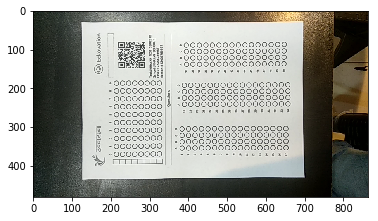

In [7]:
implt(images[0])

In [8]:
def remove_shadows(gray_scale):
    rgb_planes=cv2.split(gray_scale)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img=np.ones(shape=diff_img.shape)
        norm_img=cv2.normalize(diff_img,norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
    result = cv2.merge(result_planes)
    return cv2.merge(result_norm_planes)


In [9]:
def get_answers(questionCnts, thresh, ANSWER_KEY,paper):
    ans_array=[]
    for (q, i) in enumerate(np.arange(0, len(questionCnts), 4)):
        

        cnts = contours.sort_contours(questionCnts[i:i + 4])[0]
        bubbled = None
        flag=False

        for (j, c) in enumerate(cnts):

            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)


            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)

            if (flag and total>135): ##eariler 135
                bubbled=None
                break
            if(total>135):
                flag=True

            if(total>135):
                bubbled=(total,j)

        color = (0, 0, 255)
        k = ANSWER_KEY[q]

        if bubbled and k == bubbled[1]:
            color = (0, 255, 0)
            
            ans_array.append(k)       
        elif not bubbled:
            ans_array.append("NA")
        elif bubbled and k!=bubbled[1]:
            ans_array.append(bubbled[1])  

        cv2.drawContours(paper, [cnts[k]], -1, color, 3)
    return ans_array

In [10]:
def get_roll_number(ROLL_NO, thresh):
    roll=[]
    count=-1;
    idx=0
    X_encounter=False
    for i in range(0,80, 10):
        count+=1;
        cnts = contours.sort_contours(ROLL_NO[i:i + 10])[0]
        bubbled = None
        flag=False
        for (j, c) in enumerate(cnts):

            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)

            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)

            if (flag and total>135): ##135
                bubbled=None
                break
            if(total>135):
                flag=True
            if(total>135):
                bubbled=(total,j)
            color = (0, 255, 255)
        if(bubbled):
            roll.append(str(bubbled[1]))
        else:
            roll.append("X")
            X_encounter=True
         
    return roll, X_encounter

In [11]:
def find_questions(thresh, paper):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    questionCnts = []
    

    for c in cnts:

        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        approx = cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True)
        area = cv2.contourArea(c) ##earlier 13 and 17
        if ((w >= 47 and h >=47) and (w<=61 and h<=61) and len(approx)>=8 and ar >= 0.75 and ar <= 1.2): ##make it 18 22 when circles have been resized
            questionCnts.append(c)
    return questionCnts

In [12]:
##below function for precision
def find_questions_precise(thresh, paper):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    questionCnts = []
    ## tester=cv2.drawContours(paper.copy(), cnts, -1, (255,0,0), 2)

    for c in cnts:

        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        approx = cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True)
        area = cv2.contourArea(c)
        ## print(w, h, ar, len(approx), area)
        if ((w >= 13 and h >=13) and (w<=17 and h<=17) and len(approx)>=8 and (area>110 and area<185) and ar >= 0.75 and ar <=1.33):
            questionCnts.append(c)
    return questionCnts

In [13]:
def shuffle_answers(answer, num_q):
    temp=[]
    if(num_q==30):
        for i in range(0,len(answer),2):
            temp.append(answer[i])
        for i in range(1,len(answer),2):
            temp.append(answer[i])
    else:
        for i in range(0,len(answer),3):
            temp.append(answer[i])
        for i in range(1,len(answer),3):
            temp.append(answer[i])
        for i in range(2,len(answer),3):
            temp.append(answer[i])
    return temp   
        

In [14]:
def find_edges(edged):
    cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE,
	cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    docCnt = None
    ok=False

# ensure that at least one contour was found
    if len(cnts) > 0:
	# sort the contours according to their size in
	# descending order
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
	# loop over the sorted contours
        for c in cnts:
		# approximate the contour
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c,  0.02* peri, True)

     
		# if our approximated contour has four points,
		# then we can assume we have found the paper
            if len(approx) == 4:
                docCnt = approx            
                ok=True
                break
    return docCnt

In [25]:
def evaluate_image_batch(images, num_q):
    ANSWER_KEY=prepare_answer_key(num_q)
    d=-1
    Roll_numbers=[]
    Answers=[]
    Status=[]
    for image in images:
        d+=1
        ## images have to be rotated 90 degrees first
        
        
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        score = cv2.Laplacian(image, cv2.CV_64F).var()
        print(score, d)
        
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edged = cv2.Canny(blurred, 75, 200)
        docCnt=find_edges(edged)
        paper = four_point_transform(image, docCnt.reshape(4, 2))
        warped = four_point_transform(gray, docCnt.reshape(4, 2))
        print(warped.shape[0]/warped.shape[1], d)
        ratio=(warped.shape[0]/warped.shape[1])
        paper=cv2.resize(paper, (430,600))
        warped=cv2.resize(paper, (430,600))
        warped=cv2.cvtColor(paper,cv2.COLOR_BGR2GRAY)
        warped=remove_shadows(warped)
    
        
# ensure that at least one contour was found

        
              

        
        thresh = cv2.threshold(warped.copy(), 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        questionCnts=find_questions_precise(thresh,paper)
        
        if(ratio>=1.44 or len(questionCnts)!=(80+(4*num_q))):
            print(d, "**")
            cv2.drawContours(paper, questionCnts, -1, (255,0,100), 3)
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%dquestion_not_detected.jpg"%d, paper)
            Roll_numbers.append("Flagged")
            Answers.append("Flagged")
            Status.append("Question_detection_error or circle overwriting")
            
            continue
        AllCircles = imutils.contours.sort_contours(questionCnts, method="top-to-bottom")[0]
        correct = 0
        ROLL_NO=AllCircles[0:80]
        questionCnts=AllCircles[80:]
        if(len(ROLL_NO)!=80 or len(questionCnts)!=(4*num_q)):
            print(d)
            Roll_numbers.append("Flagged")
            Answers.append("Flagged")
            cv2.drawContours(paper, questionCnts, -1, (255,0,100), 3)
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%dquestion_not_detected.jpg"%d, paper)
            Status.append("Question_detection_error or circle overwriting")
            continue
        cv2.drawContours(paper, ROLL_NO, -1, (255,0,100), 3)
        try:
            answers=get_answers(questionCnts, thresh, ANSWER_KEY, paper)
        except:
            print(d, "***")
            Roll_numbers.append("Flagged")
            Answers.append("Flagged")
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%derror_get_answers.jpg"%d, paper)
            Status.append("Answer_retrieval/click again")
            continue
        try:
            Roll_no, X_encountered=get_roll_number(ROLL_NO, thresh)
        except:
            print(d, "****")
            Roll_numbers.append("Flagged")
            Answers.append("Flagged")
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%derror_get_rolls.jpg"%d, paper)
            Status.append("Roll_retrieval/click again")
            continue
        Roll_numbers.append(Roll_no)
        answers=shuffle_answers(answers, num_q)
        Answers.append(answers)
        if(X_encountered):
            Status.append("Successful, check for X")
        else:
            Status.append("Successful")
        cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%dresult.jpg"%d, paper)    
    return Roll_numbers, Answers, Status

In [24]:
rolls, answers, status=evaluate_image_batch(images, 50)

2734.146651367224 0
1.4148148148148147 0
0 **
2396.3230532077855 1
1.417948717948718 1
1 **
1583.5912398726323 2
1.4408284023668638 2
2 **
2522.672310864069 3
1.4116022099447514 3
3 **
2234.10492972234 4
1.4076246334310851 4
4 **
2832.5104997477833 5
1.413265306122449 5
5 **
2836.705973407945 6
1.4095477386934674 6
6 **
2445.06446485291 7
9.384615384615385 7
7 **
2814.644560292057 8
1.4214659685863875 8
8 **
2428.7030118755565 9
1.3887468030690537 9
9 **
2100.2097931548387 10
1.3959899749373434 10
10 **
1981.1806337877222 11
1.454320987654321 11
11 **
1556.7384628982259 12
1.4727722772277227 12
12 **
1978.140174094479 13
1.4090909090909092 13
13 **
2391.3610386388136 14
1.393162393162393 14
14 **
2269.1541660039393 15
1.4067357512953367 15
15 **
2490.1045886593274 16
1.3934426229508197 16
16 **
2119.464699495797 17
1.4065656565656566 17
17 **
2729.5395567492146 18
1.3952879581151831 18
18 **
2537.5548121790257 19
1.3910614525139664 19
19 **
2758.0273121686837 20
1.3979057591623036 20
2


        print(d, "out of" ,len(images), "processed")
        ans_array=[]
        ## image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ## gray=cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
        edged=edges_det(image,200,250)
        edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, np.ones((5, 11)))
        conts=find_page_contours(edged, resize(image))
        contoured=cv2.drawContours(resize(image.copy()), [conts], -1, (0, 255, 0), 3)
        conts=conts.dot(ratio(image))
        if(conts[0][0]==0):
            Roll_numbers.append("Flagged")
            Answers.append("Flagged")
            cv2.imwrite(r"C:\Users\Gautam\Desktop\OMR\RESULTS\%dpagenotdetected.jpg"%d, contoured)
            print(d, "*")
            Status.append("Page_Detect_Error")
            continue
        paper = persp_transform(image, conts)
        warped = persp_transform(gray, conts)
        warped=resize(warped)
        paper=resize(paper)

In [154]:
mapping=list(zip(rolls,answers, status))

In [45]:
import pandas as pd
df=pd.DataFrame(mapping, columns=['Roll_number','Answers', 'Status'])
df.head(n=10)

,Roll_number,Answers,Status
0,"[X, X, X, X, X, X, X, X]","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...","Successful, check for X"
1,"[X, X, X, X, X, X, X, X]","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...","Successful, check for X"
2,"[X, X, X, X, X, X, X, X]","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...","Successful, check for X"


In [19]:
df.to_csv("Results.csv")

## Mapping explained
mapping[i] details for ith student

mapping[i][0] is the roll number of ith student in list form

mapping[i][1] returns answer array of ith student 

In [20]:
image = cv2.cvtColor(cv2.imread(r"C:\Users\Gautam\Desktop\OMR\IMAGES\20190622193251_orig.png"), cv2.COLOR_BGR2RGB)
gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged=edges_det(image, 200, 250)


In [21]:
cv2.imwrite("image.jpg", image)
cv2.imwrite("gray.jpg", gray)
cv2.imwrite("edged.jpg", edged)
edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, np.ones((5, 11))) ## closing operation after finding edges close the gaps

In [22]:
cv2.imwrite("edgedn.jpg", edged)

True

In [ ]:
conts=find_page_contours(edged, resize(image))
implt(image)
image.shape

In [ ]:
contoured=cv2.drawContours((image.copy()), [conts], -1, (0, 255, 0), 3)

In [ ]:
paper=(cv2.rotate(image,rotateCode=cv2.ROTATE_90_CLOCKWISE))
warped=(cv2.rotate(gray,rotateCode=cv2.ROTATE_90_CLOCKWISE))

In [ ]:
cv2.imwrite("11contouredn.jpg", contoured)

In [ ]:
implt(paper)

In [ ]:
conts

In [ ]:
conts=conts.dot(ratio(image))

In [ ]:
cv2.imwrite("5contoured.jpg", contoured)

In [ ]:
##paper = persp_transform(image, conts)
##warped = persp_transform(gray, conts)

In [ ]:
##paper=image
##warped=gray

## EXPERIMENTAL LINE

In [ ]:
implt(paper)

In [ ]:
##  cnts = cv2.findContours(warped.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
## cv2.drawContours(warped, cnts, -1, (0,255,0), 3)

In [ ]:
cv2.imwrite("6paper.jpg", paper)
cv2.imwrite("7warped.jpg", warped)
##warped=resize(warped)
##paper=resize(paper)

In [ ]:
implt(warped)

ratio=(warped.shape[1]/warped.shape[0])
ratio=np.int0(ratio)
upsampled=np.ones(warped.shape)
upsampled=cv2.pyrUp(warped, upsampled)

upsampled.shape
implt(upsampled)

In [ ]:
def remove_shadows(gray_scale):
    rgb_planes=cv2.split(gray_scale)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img=np.ones(shape=diff_img.shape)
        norm_img=cv2.normalize(diff_img,norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
    result = cv2.merge(result_planes)
    return cv2.merge(result_norm_planes)



In [ ]:
warped=remove_shadows(warped)
implt(warped)

In [ ]:
warpedcopy=cv2.resize(warped, (430,600))
papercopy=cv2.resize(paper, (430,600))

In [ ]:
thresh = cv2.threshold(warpedcopy, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [ ]:
## thresherode=cv2.erode(thresh, np.ones((3,3), np.uint8))
## threshopen=cv2.dilate(thresherode, np.ones((3,3), np.uint8))

In [ ]:
print(thresh.shape[1])
thresh.shape[0]

In [ ]:
cv2.imwrite("13eroded.jpg", thresherode)

ratio=(thresh.shape[1]/thresh.shape[0])
upsampled=np.ones(thresh.shape)
upsampled=cv2.pyrUp(thresh, upsampled, (800, 594))

upsampled.shape

implt(upsampled)

In [ ]:
cv2.imwrite("8thresh.jpg", thresh)

In [ ]:
implt(thresh)

In [ ]:
def find_questions(thresh, paper):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    questionCnts = []
    tester=cv2.drawContours(paper.copy(), cnts, -1, (255,0,0), 2)

    for c in cnts:

        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        approx = cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True)
        area = cv2.contourArea(c)
        print(w, h, ar, len(approx), area)
        if ((w >= 12 and h >=12) and (w<=16 and h<=16) and (area>90 and area<200) and len(approx)>=8 and ar >= 0.8 and ar <= 1.4):
            questionCnts.append(c)
    return questionCnts

In [ ]:
test_conts=cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
test_conts=imutils.grab_contours(test_conts)
tester=cv2.drawContours(paper.copy(), test_conts, -1, (255,0,0), 2)
cv2.imwrite("tester.jpg", tester)
AllTests=imutils.contours.sort_contours(test_conts, method="top-to-bottom")[0]
xyz=[]
for c in AllTests:    
    (x, y, w, h) = cv2.boundingRect(c)
    approx = cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True)
    area = cv2.contourArea(c)
    print(w,h,w/float(h),len(approx), area)
        

In [ ]:
questionCnts=find_questions(thresh, paper)
AllCircles = imutils.contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0

maxm = []
##ans_array=[]
##roll=[]

In [ ]:
tester2=cv2.drawContours(paper.copy(), xyz, -1, (255,0,0), 2)
cv2.imwrite("test2.jpg", tester2)

In [ ]:
ROLL_NO=AllCircles[0:80]
questionCnts=AllCircles[80:]

In [ ]:
questionCnts=imutils.contours.sort_contours(questionCnts, method="top-to-bottom")[0]

In [ ]:
num_q=30

In [ ]:
print(len(ROLL_NO))
print(len(questionCnts))
if(len(ROLL_NO)!=80):
    raise Exception("All Roll numbers not recognised, please take pic again")
if(len(questionCnts)!=(num_q*4)):
    raise Exception("All questions not recognised, please take pic again")

In [ ]:
cv2.drawContours(cv2.resize(paper, (430,600)), ROLL_NO, -1, (255,0,100), 3)
cv2.imwrite("12rolls.jpg", paper)

## DEBUGGING CELL




for (q, i) in enumerate(np.arange(0, len(questionCnts), 4)):
	count+=1
	# sort the contours for the current question from
	# left to right, then initialize the index of the
	# bubbled answer
	cnts = contours.sort_contours(questionCnts[i:i + 4])[0]
	bubbled = None
	flag=False
	# loop over the sorted contours
	for (j, c) in enumerate(cnts):
		# construct a mask that reveals only the current
		# "bubble" for the question
		mask = np.zeros(thresh.shape, dtype="uint8")
		cv2.drawContours(mask, [c], -1, 255, -1)

		# apply the mask to the thresholded image, then
		# count the number of non-zero pixels in the
		# bubble area
		mask = cv2.bitwise_and(thresh, thresh, mask=mask)
		total = cv2.countNonZero(mask)

		minm.append(total)
          
		# if the current total has a larger number of total
		# non-zero pixels, then we are examining the currently
		# bubbled-in answer
		if bubbled is None or total > bubbled[0]:
			bubbled = (total, j) # What ???
	maxm.append(bubbled[0])
	# initialize the contour color and the index of the
	# *correct* answer
	color = (0, 0, 255)
	k = ANSWER_KEY[q]
	if k == bubbled[1]:
			color = (0, 255, 0)
			correct += 1        
	# check to see if the bubbled answer is correct 
	# draw the outline of the correct answer on the test
	cv2.drawContours(paper, [cnts[k]], -1, color, 3)

print(minm)
for o in minm:
    maxm.remove(o)
print(maxm)


In [ ]:
minm=[]
maxm=[]

In [ ]:
def get_answers(questionsCnts, thresh, ANSWER_KEY, ans_array):
    for (q, i) in enumerate(np.arange(0, len(questionCnts), 4)):
        

        cnts = contours.sort_contours(questionCnts[i:i + 4])[0]
        bubbled = None
        flag=False

        for (j, c) in enumerate(cnts):

            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)


            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)
            minm.append(total)
            if (flag and total>700): ##was 220
                bubbled=None
                break
            if(total>700):
                flag=True

            if(total>700):
                bubbled=(total,j)
        
        color = (0, 0, 255)
        k = ANSWER_KEY[q]

        if bubbled and k == bubbled[1]:
            color = (0, 255, 0)
            ans_array.append(k)       
        elif not bubbled:
            ans_array.append("NA")
        elif bubbled and k!=bubbled[1]:
            ans_array.append(bubbled[1])  

        cv2.drawContours(papercopy, [cnts[k]], -1, color, 3)
    return ans_array

In [ ]:
def get_roll_number(ROLL_NO, thresh):
    roll=[]
    count=-1;
    idx=0
    for i in range(0,80, 10):
        count+=1;
        cnts = contours.sort_contours(ROLL_NO[i:i + 10])[0]
        bubbled = None
        flag=False
        for (j, c) in enumerate(cnts):

            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)

            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)
            maxm.append(total)
            if (flag and total>700):
                bubbled=None
                break
            if(total>700):
                flag=True
            if(total>700):
                bubbled=(total,j)
            color = (0, 255, 255)
        if(bubbled):
            roll.append(bubbled[1])
        else:
            roll.append("X")
         
    return roll

In [ ]:
questions=cv2.drawContours(warpedcopy.copy(), questionCnts, -1, (0,255,0), 3)


In [ ]:
cv2.imwrite("9questions.jpg", questions)

In [ ]:
implt(questions)

In [ ]:

ans_array=[]
ans_array=get_answers(questionCnts, thresh, ANSWER_KEY, ans_array)
roll=get_roll_number(ROLL_NO, thresh)
print(ans_array)
print(len(ans_array))
print(roll)

In [ ]:
score = (correct / len(questionCnts)) * 100
print(correct)
print("[INFO] Score: {:.0f}%".format(score))
cv2.putText(paper, "{:.0f}%".format(score), (10, 30),
cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2.imshow("Result", papercopy)
cv2.imwrite("Result.jpg", papercopy)
cv2.waitKey(10000)
cv2.destroyAllWindows()

In [ ]:
def write_to_csv(ans_array, filename):
    file=open(filename, "w+")
    for x in ans_array:
        file.write(str(x))
        file.write(',')
    file.close()    

In [ ]:
write_to_csv(ans_array, "abc.txt")